In [4]:
import numpy as np
import math
import pandas as pd
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from netCDF4 import Dataset

from sklearn.preprocessing import MinMaxScaler


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

import pickle
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from numpy import linspace
from numpy import meshgrid
from scipy import signal

import matplotlib.pyplot as plt
import Rung as rg
plt.rcParams["figure.figsize"] = (20,10)

In [5]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(np.array(diff))    


In [6]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def deseasonalize(data,freq=12):
    """
    The shape of data should be (time, index) 
    """
    n  = data.shape[1]
    N  = data.shape[0]
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = np.copy(data[:,i])
        r = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            if temp[Idx].std() == 0:
                r[Idx] = 0
            else:
                r[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
        data_deseasonal[:,i] = np.copy(r)
    return(data_deseasonal)


ET_gamma = np.load("./npy_files/ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -2
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) }

def min_MSE_finder(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)


def min_MSE_finder1(count, result_sst, link,n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]
    refined_link = []
    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    index = int(df.shape[0]*0.7)
    dim = df.shape[1]

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df[str(link[k,0]-1)] = result_sst[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        index = int(df.shape[0]*0.7)
        dim = df.shape[1]

        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        mse = mean_squared_error(y_pred, y_test)
        if mse < result[-1]:
            result.append(mean_squared_error(y_pred, y_test))
            refined_link.append(link[z])
    return(result,np.array(refined_link))

In [8]:
level = 12
temporal_limits = {"time_min":datetime(1976, 1, 1, 0, 0),"time_max":datetime(2010, 12, 1, 0, 0) }

ET_gamma = np.load("./npy_files/ET_gamma.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

n_components_sst = 98

# My code:

In [7]:
sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst =pf.deseasonalize(np.array(result))
#result_sst = difference(result_sst)
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

In [8]:
scale = StandardScaler()
scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(scaled_data)
#pca_model = pca.fit(data_sst)

#df_cluster_sst = pca_model.transform(scaled_data)
df_cluster_sst = pca_model.transform(data_sst)

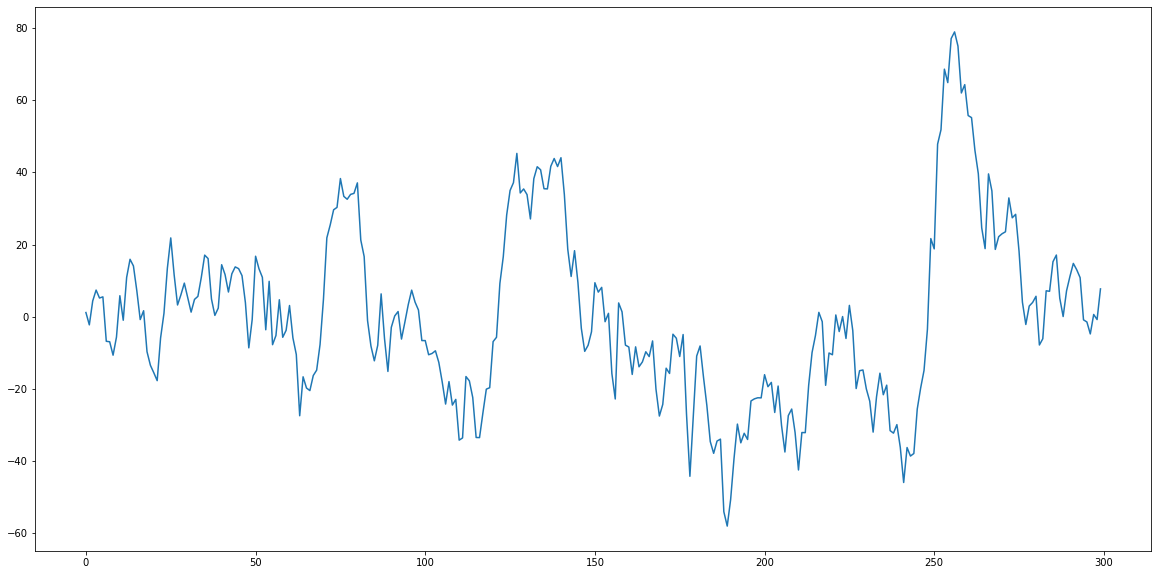

In [17]:
plt.plot(df_cluster_sst[:,1])


# Rung Code

In [9]:
sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst =pf.deseasonalize(np.array(result))
#result_sst = difference(result_sst)
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rg.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)

Vr, Rot = rg.varimax(V)
Vr = rg.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

loading_sst = pf.varimax(V, q=1000)
loading_sst = rg.svd_flip(loading_sst)
for z in range(loading_sst.shape[1]):
    loading_sst[:,z] = loading_sst[:,z] / np.linalg.norm(loading_sst[:,z])
    
loading_sst = pd.DataFrame(loading_sst)


df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [22]:
pc = 73

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


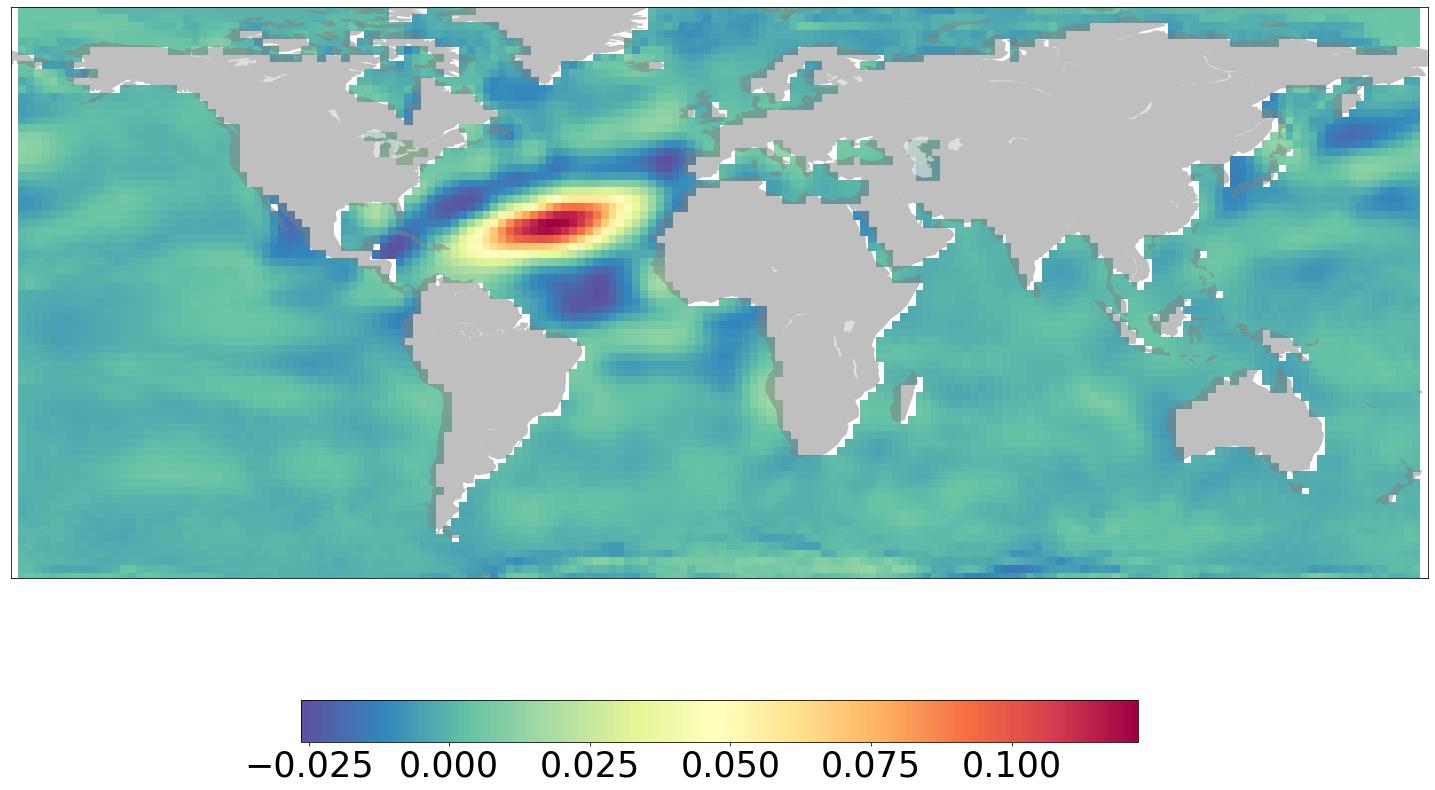

In [23]:
df_sst["pc"] = Vr[:,pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=35)
#plt.clim(-0.1,0.1)
#cbar.set_label('Loadings', fontsize = )
#plt.title("Sea Surface Temperature EOF %d"%(pc+1),fontsize = 40)
#plt.savefig("SST EOF%d_unrotated.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


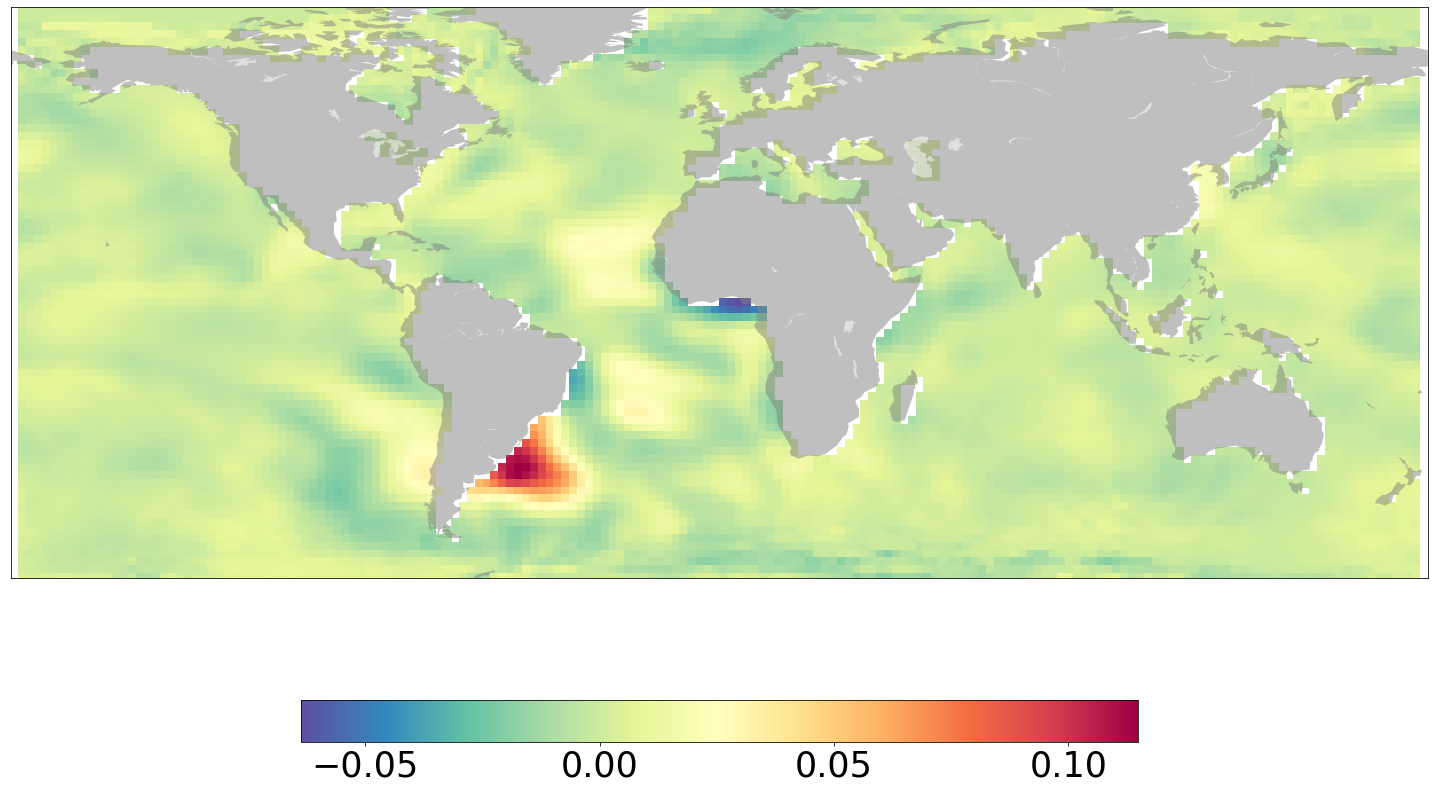

In [103]:
df_sst["pc"] = loading_sst[pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=35)
#plt.clim(-0.1,0.1)
#cbar.set_label('Loadings', fontsize = )
#plt.title("Sea Surface Temperature EOF %d"%(pc+1),fontsize = 40)
#plt.savefig("SST EOF%d_unrotated.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


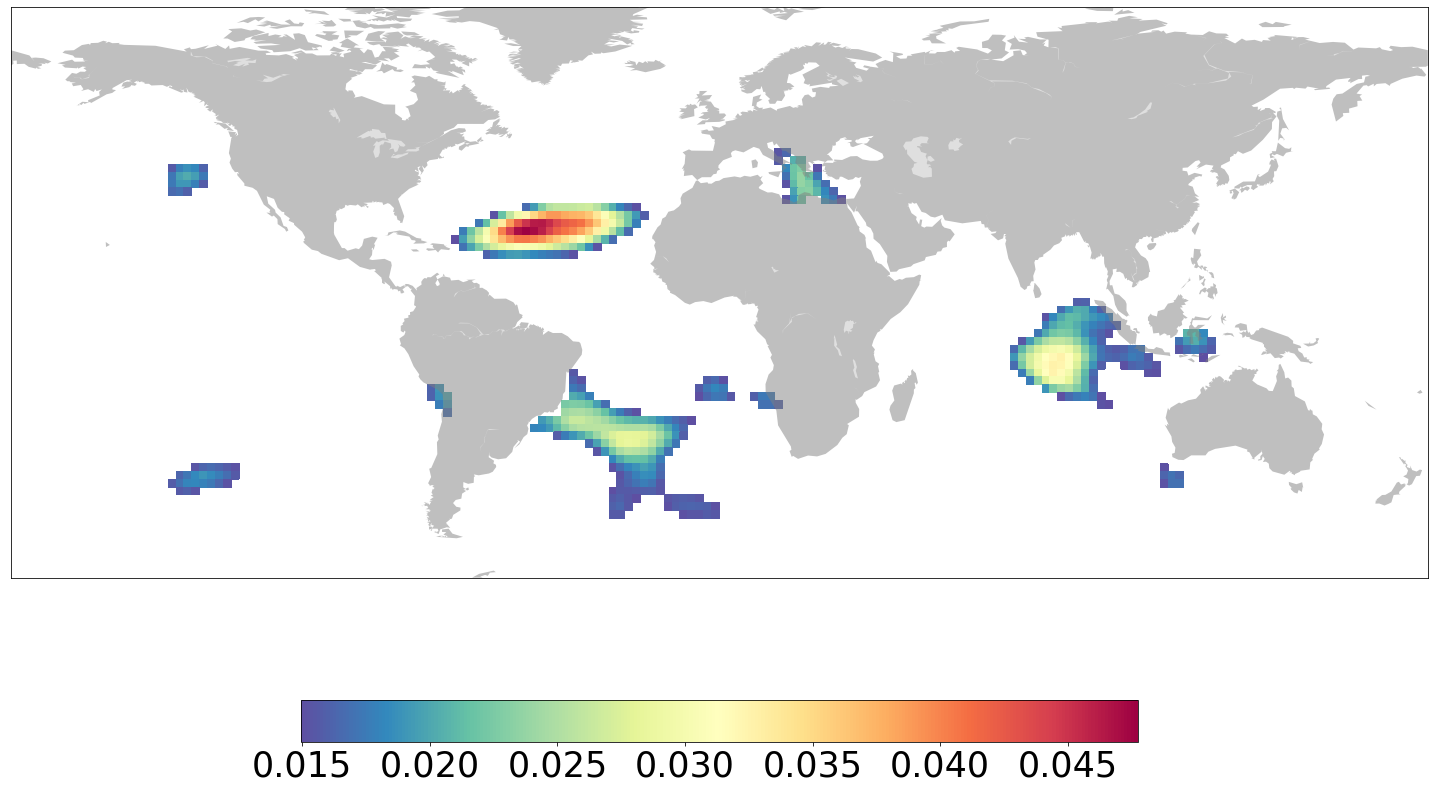

In [17]:
df_sst["pc"] = V[:,pc]

if np.abs(df_sst.pc.values.min()) > np.abs(df_sst.pc.values.max()):
    limit = np.percentile(df_sst.pc.values, 5)
    df_sst.pc.values[df_sst.pc.values>=limit]=np.nan
else:
    limit = np.percentile(df_sst.pc.values, 95)
    df_sst.pc.values[df_sst.pc.values<=limit]=np.nan
    
df_sst.pc.values[df_sst.pc.values<=limit]=np.nan

I = np.where(~np.isnan(df_sst.pc.values))

df_sst1 = df_sst.iloc[I]

#pc = 1
#df_sst["pc"] = loading_sst[pc]


#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst1[(df_sst1.lats == lat_sst[i]) & (df_sst1.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst1[(df_sst1.lats == lat_sst[i]) & (df_sst1.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
map.fillcontinents(color='grey', alpha=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=35)
#plt.clim(-0.1,0.1)
#cbar.set_label('Loadings', fontsize = )
#plt.title("Sea Surface Temperature EOF %d"%(pc+1),fontsize = 40)
#plt.savefig("SST EOF%d_unrotated.png"%(pc+1))
plt.show()

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


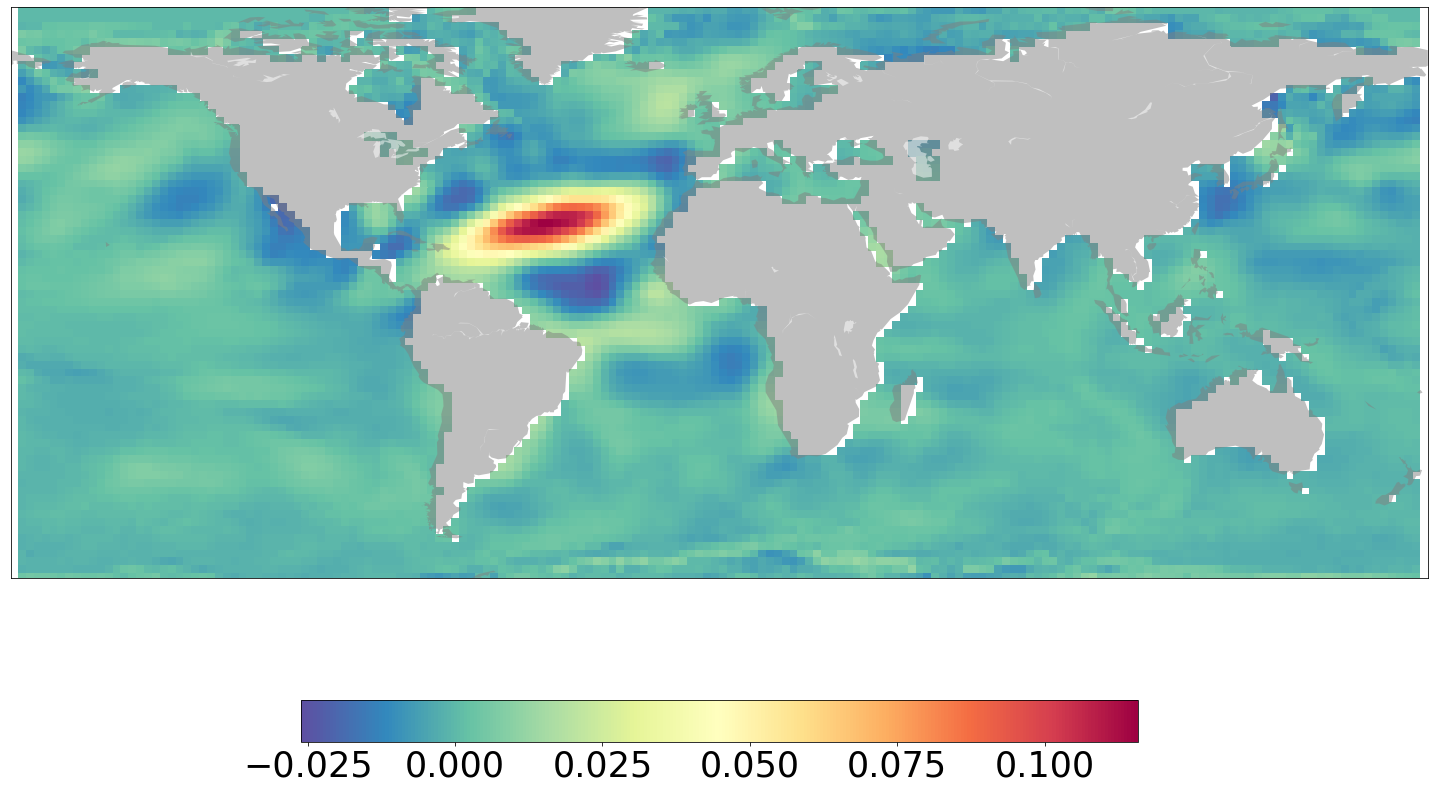

In [18]:
df_sst["pc"] = loading_sst[pc]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


plt.figure(figsize=(30,15))
# Make the background map
#map=Basemap(llcrnrlon=lon1[0], llcrnrlat=lat[-1],urcrnrlon=lon1[-1],urcrnrlat=lat[0])
map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
map.fillcontinents(color='grey', alpha=0.5)
#m.drawcoastlines(linewidth=0.1, color="white")
#map.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
#map.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=35)
#plt.clim(-0.1,0.1)
#cbar.set_label('Loadings', fontsize = )
#plt.title("Sea Surface Temperature EOF %d"%(pc+1),fontsize = 40)
#plt.savefig("SST EOF%d_unrotated.png"%(pc+1))
plt.show()

In [6]:
result_extremes = np.array(count[:ts.shape[0]])
#np.save("result_extremes_count.npy",result_extremes)


result_extremes = result_extremes.reshape((-1,1))
#result_precip = np.array(df_cluster[0])
#result_pres = np.array(df_cluster[1])
#result_sat = np.array(df_cluster[2])
result_sst = np.array(ts)
#np.save("result_sst_data.npy",result_sst)

result = np.concatenate((result_extremes,result_sst), axis=1)
result = np.array(result)

#print(result.shape)
#print(var_names)

dataframe = pp.DataFrame(result)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [116]:
results = load_obj("results_ET_197701")
q_matrix = np.load("q_matrix_ET_197701.npy")

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'], alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 54 link(s):
        (0 -1): pval = 0.00000 | val = 0.393
        (0 -11): pval = 0.00048 | val = 0.278
        (0 -12): pval = 0.00060 | val = -0.273
        (34 -1): pval = 0.00116 | val = -0.261
        (66 -3): pval = 0.00237 | val = 0.242
        (25 -5): pval = 0.00339 | val = -0.235
        (47 -2): pval = 0.00464 | val = 0.226
        (64 -2): pval = 0.00533 | val = -0.224
        (18 -4): pval = 0.00568 | val = -0.218
        (39 -11): pval = 0.00804 | val = -0.218
        (33 -10): pval = 0.00903 | val = 0.213
        (3 -7): pval = 0.01000 | val = -0.205
        (70 -5): pval = 0.01156 | val = -0.204
        (75 -1): pval = 0.01093 | val = 0.203
        (47 -9): pval = 0.01235 | val = -0.203
        (8 -11): pval = 0.01344 | val = 0.201
        (39 -12): pval = 0.01708 | val = -0.196
        (44 -8): pval = 0.01477 | val = -0.196
        (32 -8): pval = 0.01841 | val = -0.192
        (19 -9): pval = 0.01632 | val = -0

In [144]:
results = load_obj("results_ET_197701")
q_matrix = np.load("q_matrix_ET_197701.npy")

pq_matrix = results['p_matrix']
val_matrix = results['val_matrix']
alpha_level = 0.05
N = pq_matrix.shape[0]

link_dict = dict()
for j in range(N):
    # Get the good links
    good_links = np.argwhere(pq_matrix[:, j, 1:] <= alpha_level)
    # Build a dictionary from these links to their values
    links = {(i, -tau - 1): np.abs(val_matrix[i, j, abs(tau) + 1])
             for i, tau in good_links}
    # Sort by value
    link_dict[j] = sorted(links, key=links.get, reverse=True)

In [145]:
n_estimators=100
max_depth=100
tau = -3

In [146]:
link = np.array(link_dict[0])

In [147]:
link = link[link[:,0] != 0,:]

In [148]:
def time_series_maker(pc, df_sst, result, level = 95): 
    if np.abs(df_sst.pc.values.min()) > np.abs(df_sst.pc.values.max()):
        limit = np.percentile(df_sst.pc.values, 1 - level)
        df_sst.pc.values[df_sst.pc.values>=limit]=np.nan
    else:
        limit = np.percentile(df_sst.pc.values, level)
        df_sst.pc.values[df_sst.pc.values<=limit]=np.nan
    
    I = np.where(~np.isnan(df_sst.pc.values))[0]
    d = result[:,I].mean(axis=1)
    d = np.ravel(d)
    d = np.reshape(d,(-1,1))
    d = pf.deseasonalize(d)
    d = np.ravel(d)
    return(d)

In [149]:
#This is the number of observations in training set
Index = result_sst.shape[0]

In [150]:
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2006, 12, 1, 0, 0) }

In [151]:
sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst =pf.deseasonalize(np.array(result))
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

In [152]:
def min_MSE_finder_index(count, result_sst, link, index, df_sst, V, n_estimators=100, max_depth=5, tau=-1):
    result =[]
    link = link[link[:,1] <= tau]

    df = pd.DataFrame({"drought":count, "drought1":count})
    df.drought1 = df.drought1.shift(abs(tau))
    df = df.dropna()
    #index = int(df.shape[0]*0.7)
    dim = df.shape[1]
    index +=tau

    x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
    y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    result.append(mean_squared_error(y_pred, y_test))


    for z in range(len(link)):
        df = pd.DataFrame({"drought":count, "drought1":count})
        df.drought1 = df.drought1.shift(abs(tau))
        for k in range(0,z+1):
                if link[k,0] != 0:
                    df_sst["pc"] = V[:,link[k,0]-1]
                    df[str(link[k,0]-1)] = time_series_maker(link[k,0]-1, df_sst, result_sst)
                    #print(k)
                    df[str(link[k,0]-1)] = df[str(link[k,0]-1)].shift(abs(link[k,1]))
                else:
                    df[str(link[k,0])] = count
                    df[str(link[k,0])] = df[str(link[k,0])].shift(abs(link[k,1]))
        df = df.dropna()
        #index = int(df.shape[0]*0.7)
        dim = df.shape[1]
        index +=tau
        
        x_train, x_test = df.iloc[:index,1:dim], df.iloc[index:,1:dim] 
        y_train, y_test = df.iloc[:index,0], df.iloc[index:,0] 
        model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        result.append(mean_squared_error(y_pred, y_test))
    return(result,link)

In [153]:
#np.random.shuffle(link[1:,:])

result, link = min_MSE_finder_index(count[:result_sst.shape[0]], result_sst, link, Index, df_sst, V, n_estimators, max_depth,tau)

overall_min_MSE = []
overall_min_MSE.append(min(result))

Text(0, 0.5, 'MSE')

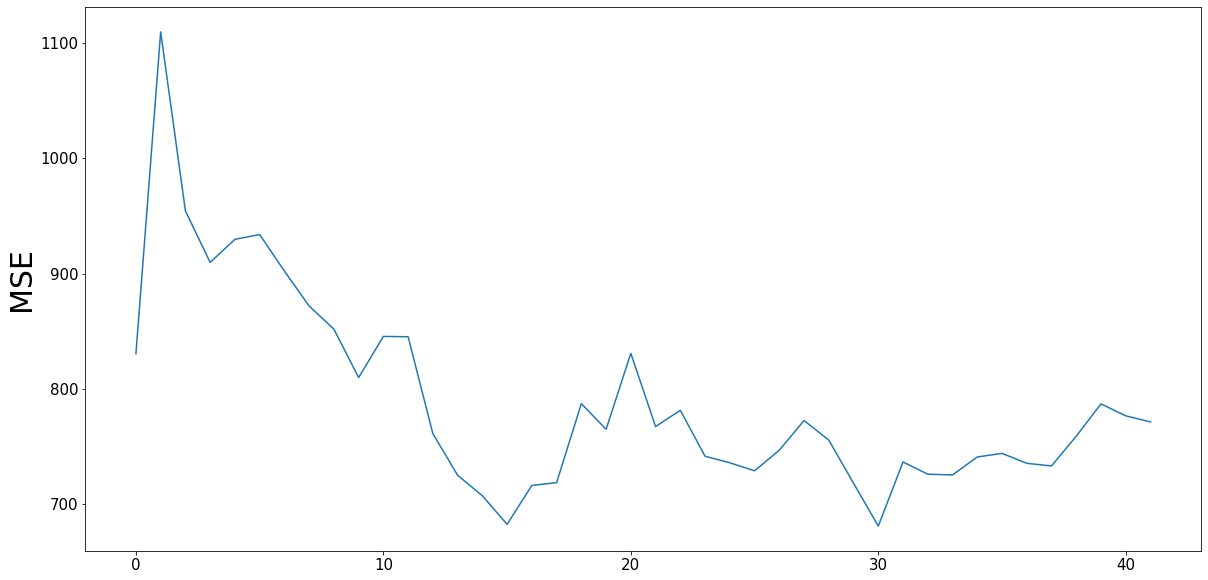

In [154]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [163]:
link

array([[ 70,  -5],
       [ 32,  -8],
       [ 66,  -9],
       [ 63, -12],
       [ 50, -11],
       [  7, -10]])

In [156]:
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]

I = np.array(diff) < 0 
#I = np.insert(I, 0, True)

#link = np.array(link_dict[0])[I,:]
link = link[I,:]
result, link = min_MSE_finder_index(count[:result_sst.shape[0]], result_sst, link, Index, df_sst, V, n_estimators, max_depth,tau)

In [157]:
link_list = []
diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
I = np.array(diff) < 0 
while not all(I):
    link_list.append(link)
    link = link[I,:]
    result, link = min_MSE_finder_index(count[:result_sst.shape[0]], result_sst, link, Index, df_sst, V, n_estimators, max_depth,tau)
    overall_min_MSE.append(min(result))
    diff = [x - result[i - 1] for i, x in enumerate(result)][1:]
    I = np.array(diff) < 0

Text(0, 0.5, 'MSE')

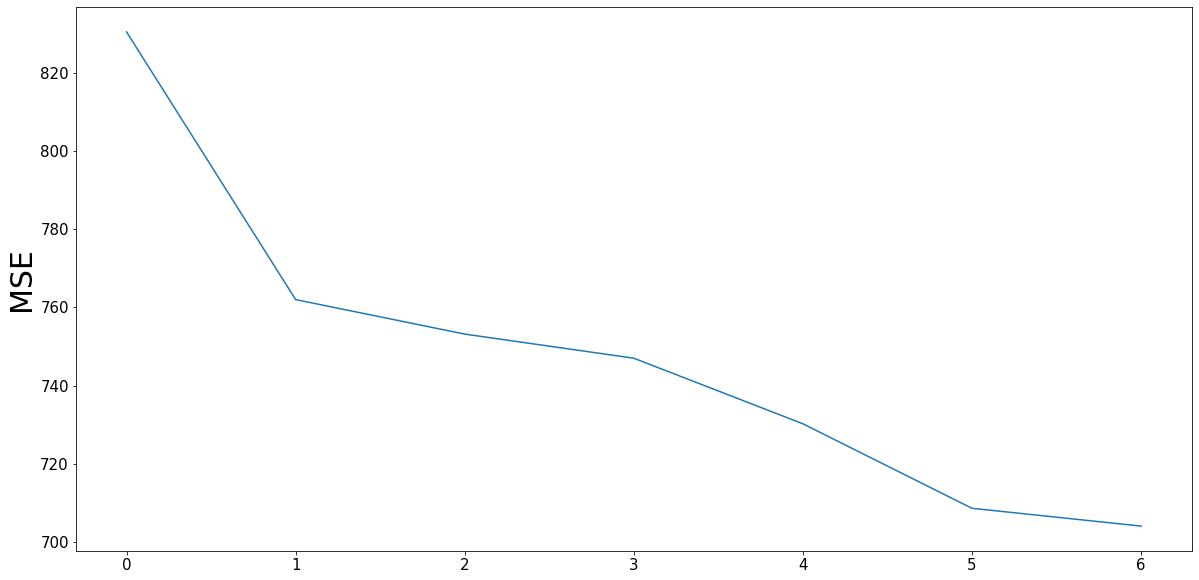

In [158]:
plt.plot(result)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel("MSE",fontsize = 30)

In [159]:
overall_min_MSE

[681.0778660248945, 634.5798627529042, 706.5204202826003, 704.0756307683849]

In [160]:
index = np.where(np.array(overall_min_MSE) == np.array(overall_min_MSE).min())[0][-1]

In [161]:
best_links = link_list[index-1]

In [164]:
best_links

array([[ 25,  -5],
       [ 18,  -4],
       [  3,  -7],
       [ 70,  -5],
       [ 47,  -9],
       [  8, -11],
       [ 44,  -8],
       [ 32,  -8],
       [ 19,  -9],
       [ 66,  -9],
       [ 63, -12],
       [ 56,  -6],
       [ 36, -10],
       [ 50, -11],
       [ 52,  -5],
       [ 42,  -9],
       [ 43,  -8],
       [ 33,  -3],
       [ 62,  -6],
       [ 76,  -8],
       [ 56,  -9],
       [ 58,  -6],
       [  7, -10],
       [ 16,  -4],
       [ 55,  -8]])